In [1]:
using Revise
using LoopVectorization
using Distributions
using BeamPropagation, StaticArrays, DelimitedFiles, BenchmarkTools
using Plots, StructArrays, StatsBase, StatsPlots
using PhysicalConstants.CODATA2018

┌ Info: Precompiling BeamPropagation [3b7771b3-0fff-45f6-8d8e-6a934b658944]
└ @ Base loading.jl:1278


# Define constants

In [1288]:
# Define constants
const h = PlanckConstant.val
const ħ = h / 2π
const λ = @with_unit 626 "nm"
const k = 2π / λ
const m = @with_unit 57 "u"
const Γ = @with_unit 2π * 8.3 "MHz"
const Iₛ = @with_unit 5.0 "mW/cm^2"
const w = @with_unit 2.5 "cm"
const P = @with_unit 250.0 "mW"
const μ = @with_unit 1 "μB"
;

In [1316]:
# CBGB properites
vz_μ = @with_unit 50 "m/s"
vz_σ = @with_unit 30/2.35 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 5 "m/s"
exit_radius = @with_unit 5 "mm"
z_start = @with_unit (-26.4-40) "cm"

const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(z_start, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

# Magnetic field setup

In [1317]:
# Prepare magnetic field data
Barr = readdlm("./B_realistic_fieldAndGrad.txt")
xin = Barr[:,1]; yin = Barr[:,2]; zin = Barr[:,3]
Bnormin = Barr[:,4]
dBdxin = Barr[:,5]; dBdyin = Barr[:,6]; dBdzin = Barr[:,7]

# make look up tables
dFlut = Array{SVector{2, Float64}}(undef, 401, 1601)
Bnormlut = zeros(Float64, (401,1601))

for (i, (x,z)) in enumerate(zip(xin, zin))
    ix = round(Int, x/(0.018)*400+1)
    iz = round(Int, (z+0.264)/(2*0.264)*1600+1)
    
    dFlut[ix,iz] = SVector(dBdxin[i], dBdzin[i]) * (μ/m)
    Bnormlut[ix,iz] = Bnormin[i]
end

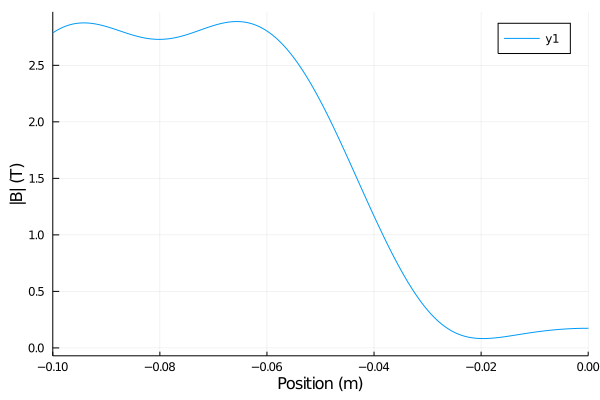

In [1318]:
plot(unique(zin),Bnormlut[1,:], xaxis="Position (m)", yaxis="|B| (T)")
xlims!(-0.1,0.0)

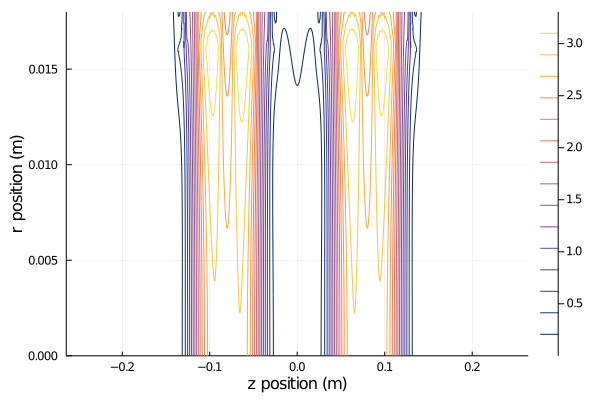

In [1319]:
contour(unique(zin),unique(xin),Bnormlut, c=:thermal)
xlabel!("z position (m)")
ylabel!("r position (m)")

In [1320]:
rectangle(w, h, x, y) = Shape(x-(w/2) .+ [0,w,w,0], y .+ [0,0,h,h])

function plotmagnet()
    buck_outer = [0.02,0.0105,-0.132,0.016]
    buck_inner = [0.012,0.0105,-0.028,0.016]
    sol_outer = [0.026, 0.023, 0.1, 0.016]
    sol_inner = [0.026, 0.023, 0.06, 0.016]
    plot(rectangle(buck_outer[1],buck_outer[2],buck_outer[3],buck_outer[4]),color="grey")
    plot!(rectangle(buck_outer[1],-buck_outer[2],buck_outer[3],-buck_outer[4]),color="grey")
    plot!(rectangle(buck_outer[1],buck_outer[2],-buck_outer[3],buck_outer[4]),color="grey")
    plot!(rectangle(buck_outer[1],-buck_outer[2],-buck_outer[3],-buck_outer[4]),color="grey")
    plot!(rectangle(buck_inner[1],buck_inner[2],buck_inner[3],buck_inner[4]),color="grey")
    plot!(rectangle(buck_inner[1],-buck_inner[2],buck_inner[3],-buck_inner[4]),color="grey")
    plot!(rectangle(buck_inner[1],buck_inner[2],-buck_inner[3],buck_inner[4]),color="grey")
    plot!(rectangle(buck_inner[1],-buck_inner[2],-buck_inner[3],-buck_inner[4]),color="grey")
    plot!(rectangle(sol_outer[1],sol_outer[2],sol_outer[3],sol_outer[4]),color="grey")
    plot!(rectangle(sol_outer[1],-sol_outer[2],sol_outer[3],-sol_outer[4]),color="grey")
    plot!(rectangle(sol_outer[1],sol_outer[2],-sol_outer[3],sol_outer[4]),color="grey")
    plot!(rectangle(sol_outer[1],-sol_outer[2],-sol_outer[3],-sol_outer[4]),color="grey")
    plot!(rectangle(sol_inner[1],sol_inner[2],sol_inner[3],sol_inner[4]),color="grey")
    plot!(rectangle(sol_inner[1],-sol_inner[2],sol_inner[3],-sol_inner[4]),color="grey")
    plot!(rectangle(sol_inner[1],sol_inner[2],-sol_inner[3],sol_inner[4]),color="grey")
    plot!(rectangle(sol_inner[1],-sol_inner[2],-sol_inner[3],-sol_inner[4]),color="grey")
end

plotmagnet (generic function with 1 method)

# Optical pumping parameters

In [1321]:
nmol = 100

num_gs = 12; num_es = 4;

TItab = [0 0.0003 0 0.0833 0 0.1656 0 0.0833 0 0.0008 0 0;
         0.0835 0 0.0830 0 0.0003 0 0.0007 0 0 0 0.1657 0;
         0 0.1662 0 0.0007 0 0.0004 0 0 0 0.0827 0 0.0833;
         0 0 0.0007 0 0.1662 0 0.0829 0 0.0831 0 0.0004 0]

BRtab = [0 0.001 0 0.167 0 0.331 0 0.167 0.333 0.002 0 0;
         0.167 0 0.166 0 0.001 0.002 0.001 0 0 0.332 0.331 0;
         0.333 0.332 0 0.001 0 0.001 0 0 0 0.165 0 0.167;
         0 0.001 0.001 0.332 0.332 0 0.166 0 0.166 0 0.001 0]

const g_to_e_TotalProb = sum(TItab, dims=1)
const end_gs = collect(1:nmol)
const μ_signs = SVector(-1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1)
const wvs = Array{Weights{Float64,Float64,Array{Float64,1}}}(undef, num_gs)

TIBRtab = zeros(Float64, num_gs, num_gs);
for g in 1:num_gs, g′ in 1:num_gs
    for e in 1:num_es
        TIBRtab[g, g′] += TItab[e, g] * BRtab[e, g′] # Probability of gstate -> estate -> gstate′
    end
end

for g in 1:num_gs
    wvs[g] = Weights(TIBRtab[g, :])
end

In [1322]:
@inline Rsc(s, δ) =  (Γ / 2) * (s / (1 + s + 4(δ/Γ)^2))
@inline detuning(Δ, UB, vz) = 2π * (Δ + UB / h + 0*vz / λ) # multiply Doppler term by 0 since we're going transverse

@inline function Prob(g, s, δ, dt0)::Tuple{Float64, Float64}
    
    # Calculate the probability density (over time) of a photon scatter event
    p_density = Rsc(s, δ) * g_to_e_TotalProb[g]
    
    # Update the time-step of the particle such that the total probability is at most 0.1, i.e., p_density * dt <= 0.1
    if (p_density * dt0 > 0.1) && !iszero(p_density)
        dt = 0.1 / p_density
    else
        dt = dt0
    end
    
    return (dt, p_density * dt)
end

@inline function scatterphoton(ix, iz, Bnormlut, g, Δ, v, dt0)::Tuple{Float64, Bool, Int64}
        
    P0 = 2P / (Iₛ * π * w^2)
    β = P0 #P0 * exp(-(x^2 + y^2) / (2w^2))
    UB = μ * μ_signs[g] * Bnormlut[ix, iz]
    δ = detuning(Δ, UB, v)
        
    (dt, prob) = Prob(g, β, δ, dt0)
        
    if rand() > prob
        scat = false
        g′ = g
    else
        scat = true
        g′ = sample(end_gs, wvs[g])
    end
    return (dt, scat, g′)
end
;

# Propagation functions

In [1323]:
const detect_rad  = @with_unit 1.6 "cm"
const detect_zloc = @with_unit (26.4+30) "cm"
const detect_zlen = @with_unit 1.3 "cm"
const dead_rad = @with_unit 1.25 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [1480]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline discard(r,v) = (sqrt(r[1]^2+r[2]^2) > detect_rad) || (r[3] > dead_len) || (v[3] < 0)
@inline is_detectable(r) = (sqrt(r[1]^2 + r[2]^2) < detect_rad) && (detect_zloc + detect_zlen > r[3] > detect_zloc)

@inline function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        dt = particles.dt[i]
        r = particles.r[i]
        vz = particles.v[i][3]
        
        push!(s.rs[idx], r)
        push!(s.vzs[idx], vz)
        push!(s.dts[idx], dt)
    end
    return nothing
end

@inline function update(particles, p, s, dt)
    
    for i in 1:size(particles, 1)
        
        idx   = particles.idx[i]
        state = p.states[idx]
        
        r = particles.r[i]
        x, y, z = r
        v = particles.v[i]
        ρ = sqrt(x^2 + y^2)
        
        if z > -0.264 && z < 0.264
            ix = round(Int, ρ/(0.018)*400+1)
            iz = round(Int, (z+0.264)/(2*0.264)*1600+1)

            pump_region_HF_1 = 0.095
            pump_region_HF_2 = 0.065
            pump_region_LF = 0.02
            
            if (pump_region_HF_1 > abs(z) > pump_region_HF_2) && (p.lasers_on[1] || p.lasers_on[3])
                
                Δ = p.Δs[1]
                dt′, scat, state′ = scatterphoton(ix, iz, p.Bnormlut, state, Δ, v[3], p.dt0)
                particles.dt[i] = dt′
                particles.use_adaptive[i] = false
                s.photons[idx] += scat
                
            elseif (pump_region_LF > abs(z)) && (p.lasers_on[2])
                
                Δ = p.Δs[2]
                dt′, scat, state′ = scatterphoton(ix, iz, p.Bnormlut, state, Δ, v[3], p.dt0)
                particles.dt[i] = dt′
                particles.use_adaptive[i] = false
                s.photons[idx] += scat
                
            else
                state′ = state
                
                # Turn adaptive time-stepping back on outside the magnets
                particles.use_adaptive[i] = true
#                 particles.dt[i] = dt
            end
            p.states[idx] = state′
        end
        s.detectable[idx] |= is_detectable(r)
    end
    
    return nothing
end

@inline function f(idx, r, v, p)
    x, y, z = r
    ρ = sqrt(x^2 + y^2)

    state = p.states[idx]
    
    if z > -0.264 && z < 0.264            
        ix = round(Int, ρ/(0.018)*400+1)
        iz = round(Int, (z+0.264)/(2*0.264)*1600+1)
        
        # compute force and rotate to Cartesian
        a′ = - p.Bscale * μ_signs[state] * SVector(
            p.dFlut[ix, iz][1] * x / ρ,
            p.dFlut[ix, iz][1] * y / ρ,
            p.dFlut[ix, iz][2]
        )
    else # if we're not anywhere near the magnets...
        a′ = SVector(0, 0, 0)
    end
    
    return a′
end
;

# Run trajectories without optical pumping

## Lensing effect

Here, I want to see how ramping up the magnet affects the number of particles making it to the detection region. So all three pumping regions are turned off. It probably makes the most sense to scan the peak magnetic field strength by introducing a parameter "p.Bscale" which multiplies the acceleration line of the f function, and then scan that from 0 to 1. 

In [1481]:
# Parameters required by beam propagation simulation
n = 10000
save_every = 20
delete_every = 20
dt = 1e-6
dt_min = 1e-8
dt_max = 1e-5
abstol = 1e-9
max_steps = Int64(3.5e5)
;

In [1482]:
alg = "rkf12"
use_adaptive = true
;

In [1484]:
Δs = [-38e9, 2.0e9]
lasers_on = [true, true, true]
dt0 = 1e-7
states = rand(1:12, n)
Bscale = 1.0
p = @params (Δs, Bnormlut, dFlut, lasers_on, dt0, states, Bscale)

rs = [Array{SVector{3, Float64}}(undef, 0) for _ in 1:n]
vzs = [Array{Float64}(undef, 0) for _ in 1:n]
dts = [Array{Float64}(undef, 0) for _ in 1:n]
detectable = zeros(Bool, n)
photons = zeros(Int64, n)
s = @params (rs, vzs, dts, detectable, photons)

using StructArrays
particles = StructArray{Particle}(undef, n)

@time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, dt_min, dt_max, abstol)

  0.679461 seconds (109.85 k allocations: 85.805 MiB)


In [1507]:
s.photons[s.detectable][14]

6

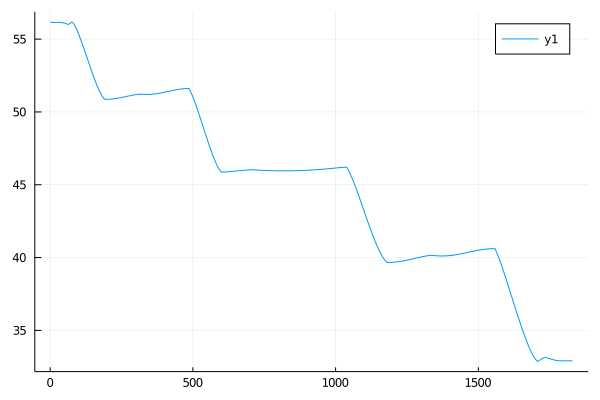

In [1509]:
plot(s.vzs[s.detectable][14])

In [1508]:
s.vzs[s.detectable][14]

1830-element Array{Float64,1}:
 56.15089921316939
 56.15089921316939
 56.15089921316939
 56.15089921316939
 56.15089921316939
 56.15089921316939
 56.15089921316939
 56.15089921316939
 56.15089921316939
 56.15089921316939
 56.15089921316939
 56.15089921316939
 56.15089921316939
  ⋮
 32.90976649777947
 32.90976649777947
 32.90976649777947
 32.90976649777947
 32.90976649777947
 32.90976649777947
 32.90976649777947
 32.90976649777947
 32.90976649777947
 32.90976649777947
 32.90976649777947
 32.90976649777947

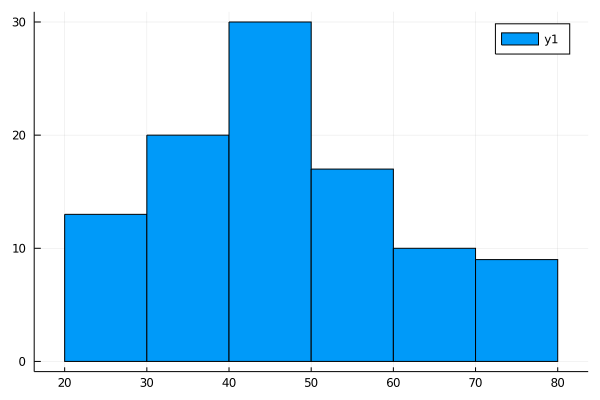

In [1473]:
histogram(s.vzs[s.detectable])


In [1462]:
detecteds = s.rs[s.detectable]
notdetecteds = s.rs[.!s.detectable][1:100:end]
;

In [1457]:
plotmagnet()
for i = 1:length(notdetecteds)
    zpts = [r[3] for r in notdetecteds[i]]
    xpts = [r[1] for r in notdetecteds[i]]
    plot!(zpts,xpts,color="red",legend=false)
end

for i = 1:length(detecteds)
    zpts = [r[3] for r in detecteds[i]]
    xpts = [r[1] for r in detecteds[i]]
    plot!(zpts,xpts,color="blue",legend=false)
end

plot!(size=(800,400))
xlabel!("Longitudinal position (m)")
ylabel!("Transverse position (m)")


In [1222]:
lasers_on = [false, false, false]
Δs = [-38e9, 2.0e9];

Bscale_list = range(0.0,stop=1.0,length=11)
detected_bscale_scan = []
detected_bscale_scan_J12 = [] # just the J=1/2 states, to simulate when we clean out J=3/2
for ib in 1:length(Bscale_list)
    vzs           = zeros(Float64, n)
    photons       = zeros(Int64, n)
    detectable    = zeros(Bool, n)
    states        = rand(1:12,n) #1*ones(Int64, n)
#     states        = 12*ones(Int64, n)
    trajectories  = [Array{Float64,1}[] for i in 1:n]
    velocities    = [Array{Float64,1}[] for i in 1:n]

    Bscale = Bscale_list[ib]
    p = @params (Δs, Bnormlut, dFlut, lasers_on, Bscale)
    s = @params (vzs, photons, detectable, states, trajectories, velocities)
    s0 = deepcopy(s)
    sf = deepcopy(s0)

    s0, sf = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0, sf)
    push!(detected_bscale_scan, sum(sf.detectable))
    push!(detected_bscale_scan_J12, sum(sf.detectable[sf.states .<= 4]))
end
;


LoadError: UndefVarError: propagate! not defined

Plot overall signal vs. B-field step, and then also plot the J=1/2 population alone.

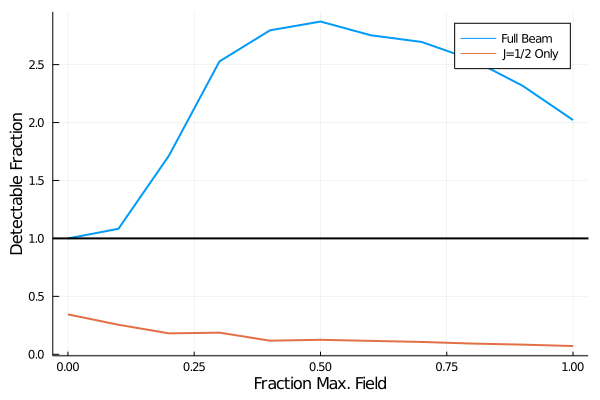

In [83]:
plot(Bscale_list, detected_bscale_scan/detected_bscale_scan[1], lw=2, label="Full Beam")
plot!(Bscale_list, detected_bscale_scan_J12/detected_bscale_scan[1], lw=2, label="J=1/2 Only")
plot!([1],seriestype=:hline, lw=2,color="black", label=false)
#ylims!(0,11)
xlabel!("Fraction Max. Field")
ylabel!("Detectable Fraction")

## Pumping in PR3 only

In [84]:
# TURN ON PUMPING LASERS
detected_12_lasers_on = []
detected_12_lasers_off = []
lasers_on = [false, false, true]
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
states        = 12*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
p  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s = @params (vzs, photons, detectable, states, trajectories, velocities)
s0 = deepcopy(s)
sf = deepcopy(s0)

s0, sf = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0, sf)

push!(detected_12_lasers_on, sum(sf.detectable[sf.states .<= 4]))

# NOW TURN OFF PUMPING LASERS AS CONTROL
lasers_on = [false, false, false]
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
states        = 12*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
p  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s = @params (vzs, photons, detectable, states, trajectories, velocities)
s0_control = deepcopy(s)
sf_control = deepcopy(s0)

s0_control, sf_control = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0_control, sf_control)

push!(detected_12_lasers_off, sum(sf_control.detectable[sf_control.states .<= 4]))

;


In [85]:
detected_12_lasers_on ./ detected_12_lasers_off

1-element Array{Float64,1}:
 Inf

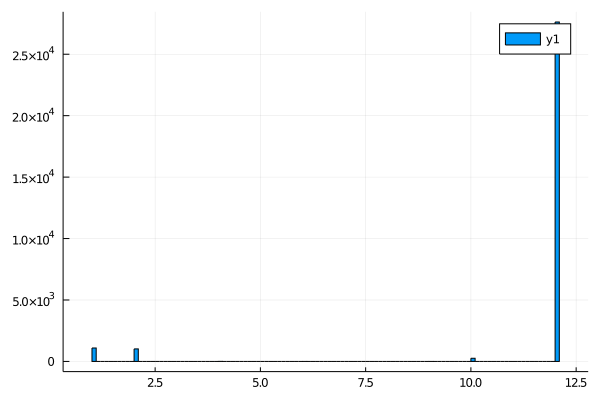

In [86]:
histogram(sf.states)

In [18]:
# HOW TO MAKE LOGICAL INDEXING WORK so that only J=1/2 population is plotted???
#pbins = range(0,stop=120,length=120)
#plot(sf.vzs[sf.detectable], lw=2.5, seriestype=:stephist, bins=pbins, label="PR1 on")
#plot!(sf_control.vzs[sf_control.detectable], lw=2.5, seriestype=:stephist, bins=pbins, label="PR1 off")
#xlims!(0,120)
#xlabel!("Velocity (m/s)")
#ylabel!("Counts")

## PR2 only

In [19]:
# TURN ON PUMPING LASERS
detected_12_lasers_on = []
detected_12_lasers_off = []
lasers_on = [false, true, false]
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
#states        = 1*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
p  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s = @params (vzs, photons, detectable, states, trajectories, velocities)
s0 = deepcopy(s)
sf = deepcopy(s0)

s0, sf = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0, sf)

push!(detected_12_lasers_on, sum(sf.detectable[sf.states .<= 4]))

# NOW TURN OFF PUMPING LASERS AS CONTROL
lasers_on = [false, false, false]
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
#states        = 1*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
p  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s = @params (vzs, photons, detectable, states, trajectories, velocities)
s0 = deepcopy(s)
sf = deepcopy(s0)

s0, sf = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0, sf)

push!(detected_12_lasers_off, sum(sf.detectable[sf.states .<= 4]))

;


In [20]:
detected_12_lasers_on ./ detected_12_lasers_off

1-element Array{Float64,1}:
 0.02857142857142857

## Pumping in PR1 only

In [21]:
# TURN ON PUMPING LASERS
detected_12_lasers_on = []
detected_12_lasers_off = []
lasers_on = [true, false, false]
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
#states        = 1*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
p  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s = @params (vzs, photons, detectable, states, trajectories, velocities)
s0 = deepcopy(s)
sf = deepcopy(s0)

s0, sf = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0, sf)

push!(detected_12_lasers_on, sum(sf.detectable[sf.states .<= 4]))

# NOW TURN OFF PUMPING LASERS AS CONTROL
lasers_on = [false, false, false]
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
#states        = 1*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
p  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s = @params (vzs, photons, detectable, states, trajectories, velocities)
s0 = deepcopy(s)
sf = deepcopy(s0)

s0, sf = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0, sf)

push!(detected_12_lasers_off, sum(sf.detectable[sf.states .<= 4]))

;


In [22]:
detected_12_lasers_on ./ detected_12_lasers_off

1-element Array{Float64,1}:
 2.793103448275862

# Plot trajectories

In [23]:
n = Int64(100000)
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
states        = 12*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
lasers_on = [true, true, true]
p  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s = @params (vzs, photons, detectable, states, trajectories, velocities)
s0 = deepcopy(s)
sf = deepcopy(s0)

s0, sf = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0, sf)

detecteds = sf.trajectories[sf.detectable][1:250:end]
notdetecteds = sf.trajectories[.!sf.detectable][1:250:end]

;

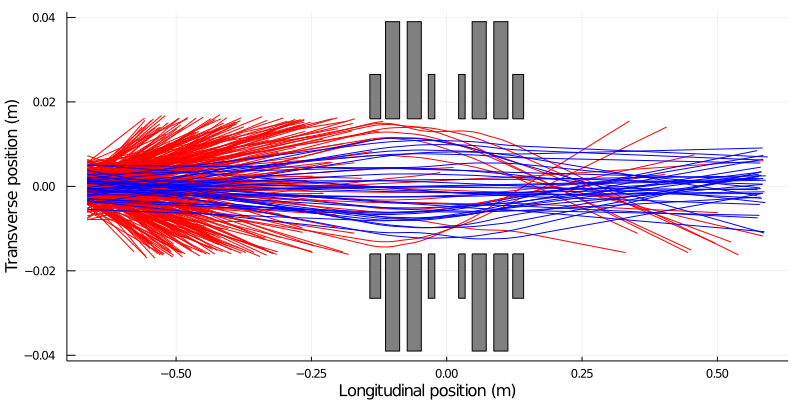

In [24]:
plotmagnet()
for i = 1:length(notdetecteds)
    zpts = [r[3] for r in notdetecteds[i]]
    xpts = [r[1] for r in notdetecteds[i]]
    plot!(zpts,xpts,color="red",legend=false)
end

for i = 1:length(detecteds)
    zpts = [r[3] for r in detecteds[i]]
    xpts = [r[1] for r in detecteds[i]]
    plot!(zpts,xpts,color="blue",legend=false)
end

plot!(size=(800,400))
xlabel!("Longitudinal position (m)")
ylabel!("Transverse position (m)")


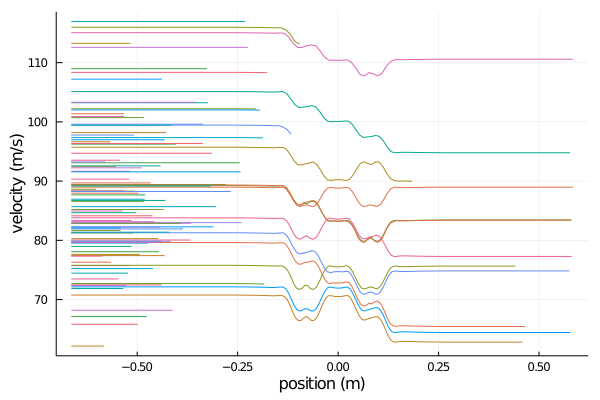

In [25]:
plot()
for i = 1:1000:n
    plot!([r[3] for r in sf.trajectories[i]],[v[3] for v in sf.velocities[i]],label=false)
end
plot!()
xlabel!("position (m)")
ylabel!("velocity (m/s)")

# Simulate slowing

## Pumping in all 3 regions

In [156]:
# CBGB properites
vz_μ = @with_unit 70 "m/s"
vz_σ = @with_unit 45/2.35 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 5 "m/s"
exit_radius = @with_unit 5 "mm"
z_start = @with_unit (-26.4-40) "cm"
const P = @with_unit 250 "mW"

const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(z_start, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [171]:
const detect_rad  = @with_unit 1.4 "cm"
const detect_zloc = @with_unit (26.4+30) "cm"
const detect_zlen = @with_unit 3.3 "cm"
const dead_rad = @with_unit 2.25 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [172]:
n = Int64(600000)
scattering_rate = @with_unit 1.6 "MHz"
save_every      = 10
delete_every    = 15
dt              = 1e-5 #1 / scattering_rate
max_steps       = Int64(3.5e4)
;

In [173]:
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
states        = 12*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
lasers_on = [true, true, true]
p  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s = @params (vzs, photons, detectable, states, trajectories, velocities)
s0 = deepcopy(s)
sf = deepcopy(s0)

@time s0, sf = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0, sf)
;


 30.479020 seconds (60.50 M allocations: 7.061 GiB, 42.29% gc time)


In [174]:
# NOW RUN A CONTROL CASE WITH NO OPTICAL PUMPING
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
states        = 12*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
lasers_on = [false, false, false]
p_control  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s_control = @params (vzs, photons, detectable, states, trajectories, velocities)
s0_control = deepcopy(s_control)
sf_control = deepcopy(s0_control)

@time s0_control, sf_control = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p_control, s0_control, sf_control)
;

 89.348017 seconds (60.37 M allocations: 7.049 GiB, 70.18% gc time)


In [175]:
detecteds = sf.trajectories[sf.detectable][1:500:end]
notdetecteds = sf.trajectories[.!sf.detectable][1:500:end]
;

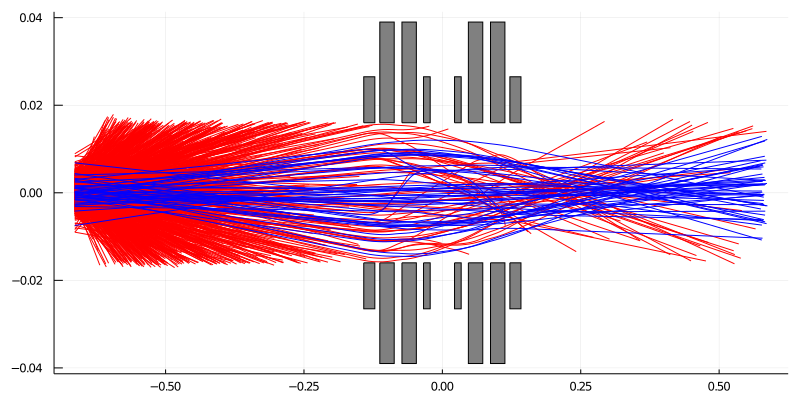

In [176]:
plotmagnet()
for i = 1:length(notdetecteds)
    zpts = [r[3] for r in notdetecteds[i]]
    xpts = [r[1] for r in notdetecteds[i]]
    plot!(zpts,xpts,color="red",legend=false)
end

for i = 1:length(detecteds)
    zpts = [r[3] for r in detecteds[i]]
    xpts = [r[1] for r in detecteds[i]]
    plot!(zpts,xpts,color="blue",legend=false)
end

plot!(size=(800,400))


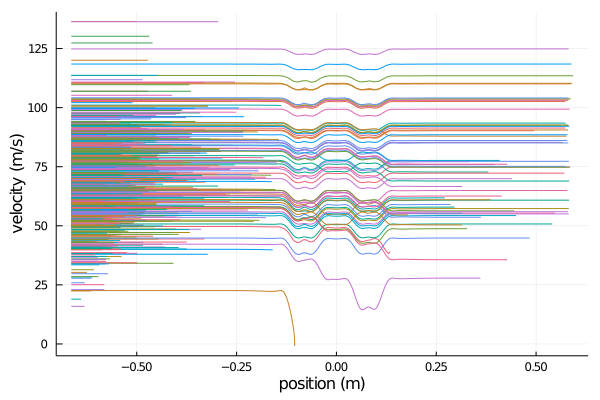

In [177]:
plot()
for i = 1:1000:n
    plot!([r[3] for r in sf.trajectories[i]],[v[3] for v in sf.velocities[i]],label=false)
end
plot!()
xlabel!("position (m)")
ylabel!("velocity (m/s)")

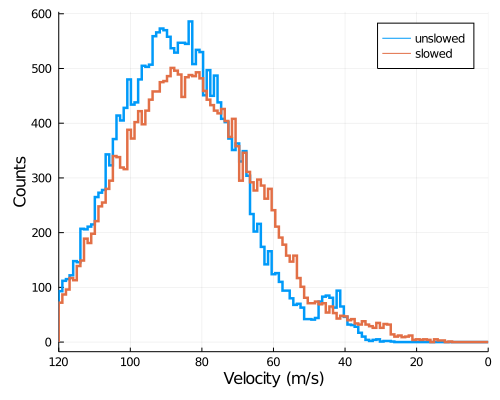

In [178]:
pbins = range(0,stop=120,length=120)
plot(sf_control.vzs[sf_control.detectable], lw=2.5, seriestype=:stephist, bins=pbins, label="unslowed", xflip=true)
plot!(sf.vzs[sf.detectable], lw=2.5, seriestype=:stephist, bins=pbins, label="slowed")
xlims!(0,120)
xlabel!("Velocity (m/s)")
ylabel!("Counts")
plot!(size=(500,400))

## Pumping in just PR1+PR2

In [ ]:
# CBGB properites
vz_μ = @with_unit 75 "m/s"
vz_σ = @with_unit 45/2.35 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 5 "m/s"
exit_radius = @with_unit 5 "mm"
z_start = @with_unit (-26.4-40) "cm"
const P = @with_unit 20 "mW"

const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(z_start, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [69]:
n = Int64(600000)
scattering_rate = @with_unit 1.6 "MHz"
save_every      = 10
delete_every    = 15
dt              = 1e-5 #1 / scattering_rate
max_steps       = Int64(3.5e4)
;

In [70]:
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
#states        = 12*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
lasers_on = [true, true, false]
p  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s = @params (vzs, photons, detectable, states, trajectories, velocities)
s0 = deepcopy(s)
sf = deepcopy(s0)

@time s0, sf = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0, sf)
;


 48.326102 seconds (57.75 M allocations: 6.710 GiB, 34.97% gc time)


In [71]:
# NOW RUN A CONTROL CASE WITH NO OPTICAL PUMPING
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
#states        = 12*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
lasers_on = [false, false, false]
p_control  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s_control = @params (vzs, photons, detectable, states, trajectories, velocities)
s0_control = deepcopy(s_control)
sf_control = deepcopy(s0_control)

@time s0_control, sf_control = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p_control, s0_control, sf_control)
;

 79.863534 seconds (56.82 M allocations: 6.594 GiB, 63.25% gc time)


In [72]:
detecteds = sf.trajectories[sf.detectable][1:500:end]
notdetecteds = sf.trajectories[.!sf.detectable][1:500:end]
;

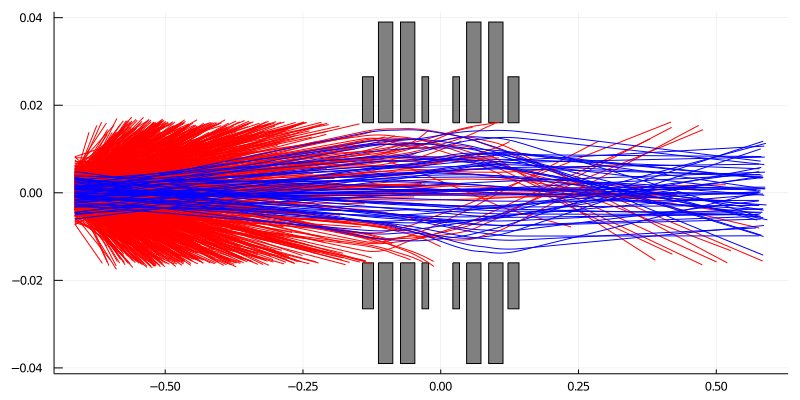

In [73]:
plotmagnet()
for i = 1:length(notdetecteds)
    zpts = [r[3] for r in notdetecteds[i]]
    xpts = [r[1] for r in notdetecteds[i]]
    plot!(zpts,xpts,color="red",legend=false)
end

for i = 1:length(detecteds)
    zpts = [r[3] for r in detecteds[i]]
    xpts = [r[1] for r in detecteds[i]]
    plot!(zpts,xpts,color="blue",legend=false)
end

plot!(size=(800,400))


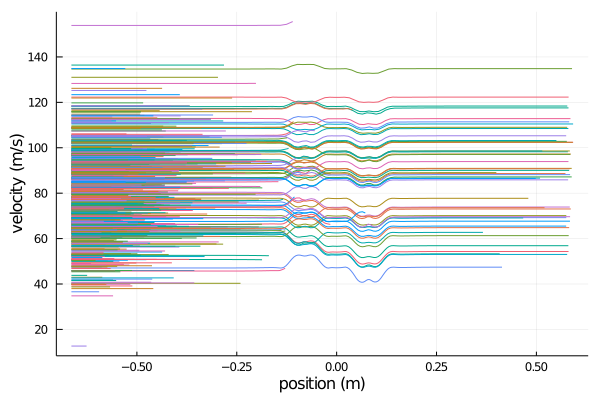

In [74]:
plot()
for i = 1:1000:n
    plot!([r[3] for r in sf.trajectories[i]],[v[3] for v in sf.velocities[i]],label=false)
end
plot!()
xlabel!("position (m)")
ylabel!("velocity (m/s)")

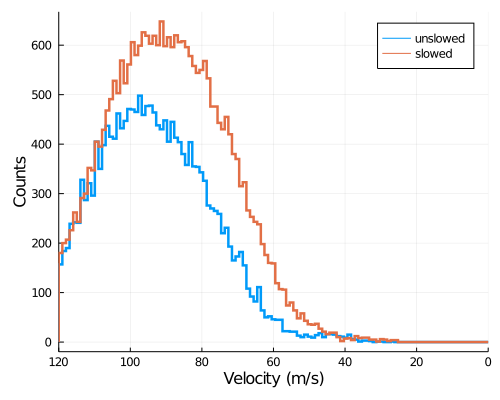

In [75]:
pbins = range(0,stop=120,length=120)
plot(sf_control.vzs[sf_control.detectable], lw=2.5, seriestype=:stephist, bins=pbins, label="unslowed", xflip=true)
plot!(sf.vzs[sf.detectable], lw=2.5, seriestype=:stephist, bins=pbins, label="slowed")
xlims!(0,120)
xlabel!("Velocity (m/s)")
ylabel!("Counts")
plot!(size=(500,400))

## Pumping in just PR2+PR3

In [76]:
# CBGB properites
vz_μ = @with_unit 80 "m/s"
vz_σ = @with_unit 45/2.35 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 5 "m/s"
exit_radius = @with_unit 5 "mm"
z_start = @with_unit (-26.4-40) "cm"

const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(z_start, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [77]:
n = Int64(600000)
scattering_rate = @with_unit 1.6 "MHz"
save_every      = 10
delete_every    = 15
dt              = 1e-5 #1 / scattering_rate
max_steps       = Int64(3.5e4)
;

In [78]:
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
#states        = 12*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
lasers_on = [false, true, true]
p  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s = @params (vzs, photons, detectable, states, trajectories, velocities)
s0 = deepcopy(s)
sf = deepcopy(s0)

@time s0, sf = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p, s0, sf)
;


142.497292 seconds (57.57 M allocations: 6.690 GiB, 80.30% gc time)


In [79]:
# NOW RUN A CONTROL CASE WITH NO OPTICAL PUMPING
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = rand(1:12,n) #1*ones(Int64, n)
#states        = 12*ones(Int64, n)
trajectories  = [Array{Float64,1}[] for i in 1:n]
velocities    = [Array{Float64,1}[] for i in 1:n]

Bscale = 1.0
lasers_on = [false, false, false]
p_control  = @params (δs, Bnormlut, dFlut, lasers_on, Bscale)
s_control = @params (vzs, photons, detectable, states, trajectories, velocities)
s0_control = deepcopy(s_control)
sf_control = deepcopy(s0_control)

@time s0_control, sf_control = propagate!(n, dt, r, v, a, f, save, discard, save_every, delete_every, max_steps, p_control, s0_control, sf_control)
;

 88.667357 seconds (56.77 M allocations: 6.587 GiB, 74.03% gc time)


In [80]:
detecteds = sf.trajectories[sf.detectable][1:500:end]
notdetecteds = sf.trajectories[.!sf.detectable][1:500:end]
;

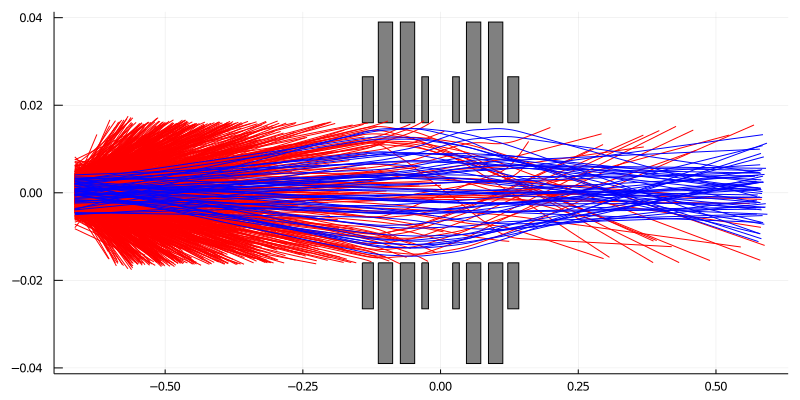

In [81]:
plotmagnet()
for i = 1:length(notdetecteds)
    zpts = [r[3] for r in notdetecteds[i]]
    xpts = [r[1] for r in notdetecteds[i]]
    plot!(zpts,xpts,color="red",legend=false)
end

for i = 1:length(detecteds)
    zpts = [r[3] for r in detecteds[i]]
    xpts = [r[1] for r in detecteds[i]]
    plot!(zpts,xpts,color="blue",legend=false)
end

plot!(size=(800,400))


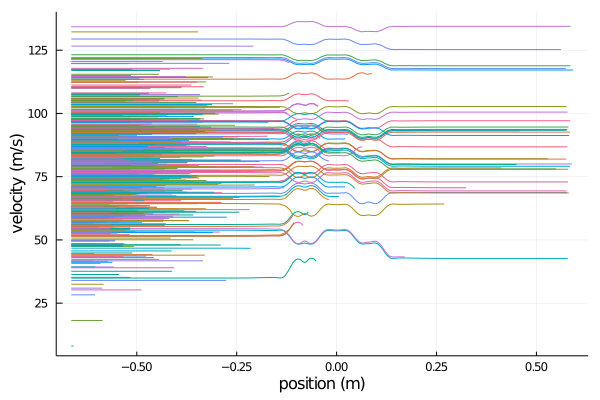

In [82]:
plot()
for i = 1:1000:n
    plot!([r[3] for r in sf.trajectories[i]],[v[3] for v in sf.velocities[i]],label=false)
end
plot!()
xlabel!("position (m)")
ylabel!("velocity (m/s)")

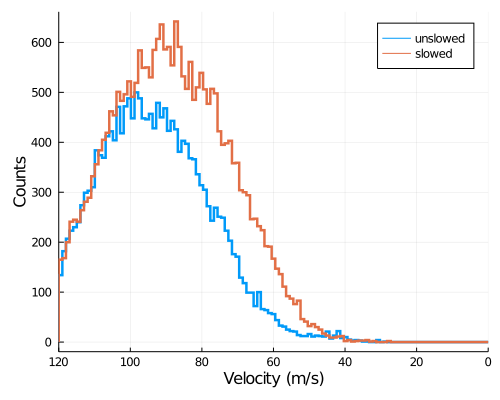

In [83]:
pbins = range(0,stop=120,length=120)
plot(sf_control.vzs[sf_control.detectable], lw=2.5, seriestype=:stephist, bins=pbins, label="unslowed", xflip=true)
plot!(sf.vzs[sf.detectable], lw=2.5, seriestype=:stephist, bins=pbins, label="slowed")
xlims!(0,120)
xlabel!("Velocity (m/s)")
ylabel!("Counts")
plot!(size=(500,400))